In [ ]:
https://github.com/MarcLefevreFr/OpenClassrooms

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost
import sklearn
from time import time
from category_encoders.target_encoder import TargetEncoder

from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, RandomizedSearchCV, cross_val_predict

from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


#
pd.options.display.max_columns = 60

# **Présentation** : Mission et Démarche

In [ ]:
Nous allons tester différents modèles (...)

In [ ]:
- choix des modèles

In [ ]:
- choix des métriques

In [ ]:
- descrip du processus, présentations, CV, ESS, méthode pipeline ou pas, encodage, etc..

# Modélisation **SiteEnergyUseWN(kBtu)**

## 1) - Etapes Préliminaires

### Définition de constantes

In [3]:
# liste des colonnes de nos df de présentations des résultats
LISTE_COL = ["Model", "Fit_Time", "Score_time", "MAE", "RMSLE", "R2"] 

# Métriques utilisées en temps normal et au cas ou la MSLE ne soit pas adaptée
SCORING = ["neg_mean_absolute_error", "neg_mean_squared_log_error", "r2"]
SCORING_alt = ["neg_mean_absolute_error", "r2"]

# facteur aléatoire que nous utiliserons le long de notre travail
SEED = 47

# nombre de "folds" lors des validation croisées
K = 5

### Définition de notre **panel initial d'estimateurs** dans un dictionnaire.

In [4]:
d_mod = {"Linear_Reg" : LinearRegression(),
        "Ridge_Reg" : Ridge(),
        "Lasso_Reg" : Lasso(),
        "SV_Reg" : SVR(),
        "DT_Reg" : DecisionTreeRegressor(),
        "RF_Reg" : RandomForestRegressor(random_state = SEED),
        "Adaboost_Reg" : AdaBoostRegressor(),
        "Bagging_Reg" : BaggingRegressor(base_estimator = DecisionTreeRegressor()),
        "GB_Reg" : GradientBoostingRegressor(random_state = SEED),
        "XGB_Reg" : xgboost.XGBRegressor(random_state = SEED)
       }

### Définition de notre fonction de **modélisation**

In [5]:
def modelize(model, name, X, y, return_model = False , graph = False, k = K) :
        
    resultats = []
    
    kf = KFold(k, shuffle = True, random_state = SEED)
    
    try :
        cv_res = cross_validate(model, X, y, scoring = SCORING, cv = kf)

        resultats.append(name)
        resultats.append(cv_res["fit_time"].sum())
        resultats.append(cv_res["score_time"].sum())
        resultats.append(-cv_res['test_neg_mean_absolute_error'].mean())
        resultats.append(np.sqrt(-cv_res['test_neg_mean_squared_log_error']).mean())
        resultats.append(cv_res['test_r2'].mean())

    
    # Si, comme cela arrive parfois, la RMSLE est impossible à calculer, on lui donne la valeur 0.
    except :
        
        cv_res = cross_validate(model, X, y, scoring = SCORING_alt, cv = kf)
        
        resultats.append(name)
        resultats.append(cv_res["fit_time"].sum())
        resultats.append(cv_res["score_time"].sum())
        resultats.append(-cv_res['test_neg_mean_absolute_error'].mean())
        resultats.append(0)  
        resultats.append(cv_res['test_r2'].mean())
    
    # affichage de graphs au choix
    if graph :

        pred = cross_val_predict(model, X, y, cv = kf)

        error = np.abs(y - pred)

        fig = plt.figure(figsize = (8, 8))
        plt.subplot(2,2,1)
        plt.scatter(y, pred, color = "coral")
        plt.subplot(2,2,2)
        plt.hist(error, bins = 50)
        plt.show()
            
    new_row = {k:v for k, v in zip(LISTE_COL, resultats)}

    # récupération d'un modèle entrainé au choix
    if return_model :
        
        return new_row, model.fit(X, y)
        
    else :        
    
        return new_row

### Chargement des **données**

In [6]:
# chargement de nos données avec et sans outliers
X = pickle.load(open("Data/X.pickle", "rb"))
y = pickle.load(open("Data/y.pickle", "rb"))

X_no = pickle.load(open("Data/X_no.pickle", "rb"))
y_no = pickle.load(open("Data/y_no.pickle", "rb"))

# Cibles du premier modèle (variable "SiteEnergyUseWN(kBtu)")
y = y["SiteEnergyUseWN(kBtu)"]
y_no = y_no["SiteEnergyUseWN(kBtu)"]

# transformation log(p+1) des cibles
y = y.transform(np.log1p)
y_no = y_no.transform(np.log1p)

### Définition de fonctions de **pre-processing**

In [7]:

# Fonction d'imputation des valeurs manquantes de la variable ESS
# Ici on impute la valeur médiane aux valeurs manquante.

def num_imput(X):
    
    med = X["ENERGYSTARScore"].median()
    X["ENERGYSTARScore"] = X["ENERGYSTARScore"].fillna(med)
    
    return X

# Fonction appliquant les transformations de nos variables quantitatives.

def num_trans(X):
    
    num_feat = np.array(X.columns[X.dtypes != "category"])
     
    for col in num_feat :
        
        X[col] = X[col].transform(np.log1p) # transformation "log(p +1)"
        std = StandardScaler().fit(np.array(X[col]).reshape(-1,1)) # standardisation
        X[col] = std.transform(np.array(X[col]).reshape(-1,1))
        
    return X

# fonction d'encodage de nos variables catégorielles
# ici c'est du OneHotEncoding grâce à pd.get_dummies()

def cat_trans(X):
    
    cat_feat = np.array(X.columns[X.dtypes == "category"])
    X = pd.get_dummies(X, drop_first = True)
    #X = pd.get_dummies(X, drop_first = True)
    return X

# fonction de transformation globale regroupant les deux fonctions précédentes

def prepro(X):
    
    X = num_imput(X)
    X = num_trans(X)
    X = cat_trans(X)
    
    return X

## 2) - 1ère Modélisation encodage **One-Hot-Encoding**

In [79]:
# Preprocessing
X = prepro(X)

# Initialisation du DataFrame de résultats
df_res = pd.DataFrame(columns = LISTE_COL)

# Boucle de modélisation
for name, model in d_mod.items():
    
    df_res = df_res.append(modelize(model, name, X, y), ignore_index = True)
    
df_res

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.160009,0.027002,0.338914,0.032464,0.808751
1,Ridge_Reg,0.062003,0.021001,0.331505,0.031672,0.818937
2,Lasso_Reg,0.065004,0.020001,0.892718,0.072055,-0.002240
3,SV_Reg,5.381306,1.155066,0.315206,0.031702,0.814440
4,DT_Reg,0.246014,0.021001,0.464662,0.046142,0.615126
5,RF_Reg,12.777730,0.119006,0.337221,0.033635,0.794065
6,Adaboost_Reg,3.094177,0.090005,0.486485,0.042374,0.666712
7,Bagging_Reg,1.507086,0.060003,0.355831,0.034985,0.776768
8,GB_Reg,3.842218,0.028002,0.324564,0.031377,0.820839
9,XGB_Reg,2.076119,0.064003,0.316152,0.031195,0.823654


**Commentaires**<br>Ces résultats constitue la base de travail que nous allons essayer d'améliorer.<br>Parmi eux, le résultat de la regression **lasso par défaut** nous pose question.

Clairement, on voit que la régression linéaire ne marche pas ici. Cette modélisation ne parvient pas à renvoyer autre chose qu'un résultat qui semble aberrant.

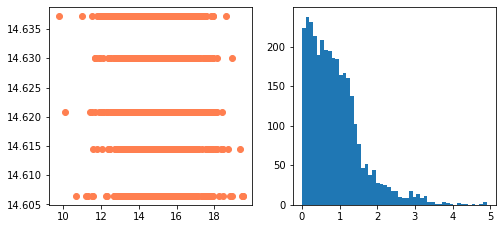

{'Model': 'XGB_Reg',
 'Fit_Time': 0.09700584411621094,
 'Score_time': 0.03400158882141113,
 'MAE': 0.892718476394694,
 'RMSLE': 0.07207918972987538,
 'R2': -0.0022402284744833523}

In [238]:
lasso = Lasso()
modelize(lasso, name, X, y, False, True)

Le graphe ci-dessous nous montre que chaque fold donne probablement des résultats bien hétérogènes. Regardons plus en détails les résultats...

In [239]:
cv_res = cross_validate(lasso, X, y, scoring = SCORING, 
                        cv = KFold(K, shuffle = True, random_state = SEED))

In [240]:
cv_res

{'fit_time': array([0.01900125, 0.02600145, 0.02000117, 0.01800084, 0.01800132]),
 'score_time': array([0.00800037, 0.00800061, 0.00600004, 0.00700045, 0.00600004]),
 'test_neg_mean_absolute_error': array([-0.92891721, -0.8869461 , -0.87290809, -0.87836227, -0.89645871]),
 'test_neg_mean_squared_log_error': array([-0.00562701, -0.00526098, -0.00487908, -0.00494031, -0.00526966]),
 'test_r2': array([-4.10120408e-03, -1.79092480e-05, -1.06028781e-03, -1.36437250e-03,
        -4.65736873e-03])}

In [241]:
cv_res['test_r2']

array([-4.10120408e-03, -1.79092480e-05, -1.06028781e-03, -1.36437250e-03,
       -4.65736873e-03])

Influence du paramètre **alpha**

In [206]:
X = pickle.load(open("Data/X.pickle", "rb"))
X = prepro(X)

error = []
lasso = Lasso()

alphas = np.linspace(0.01,10,50)

for l in alphas :
    lasso = Lasso(alpha = l)
    #lasso.set_params(alpha = l)
    cv_results = cross_validate(lasso, X, y, scoring = SCORING, cv = KFold(K, shuffle = True, random_state = SEED))
    print(cv_results)
    #coefs.append(lasso.coef_)
    error.append(-cv_results['test_neg_mean_absolute_error'].mean())

{'fit_time': array([0.01100063, 0.00900054, 0.01000071, 0.00800037, 0.01000071]), 'score_time': array([0., 0., 0., 0., 0.]), 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan]), 'test_neg_mean_squared_log_error': array([nan, nan, nan, nan, nan]), 'test_r2': array([nan, nan, nan, nan, nan])}
{'fit_time': array([0.00800061, 0.00900054, 0.0090003 , 0.0090003 , 0.00800061]), 'score_time': array([0., 0., 0., 0., 0.]), 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan]), 'test_neg_mean_squared_log_error': array([nan, nan, nan, nan, nan]), 'test_r2': array([nan, nan, nan, nan, nan])}
{'fit_time': array([0.00800061, 0.00900054, 0.00800061, 0.00800061, 0.0090003 ]), 'score_time': array([0., 0., 0., 0., 0.]), 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan]), 'test_neg_mean_squared_log_error': array([nan, nan, nan, nan, nan]), 'test_r2': array([nan, nan, nan, nan, nan])}
{'fit_time': array([0.00900078, 0.00800061, 0.00800037, 0.0090003 , 0.00800061]), 'sc

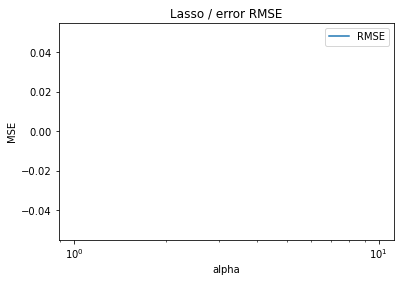

In [194]:
ax = plt.gca()

ax.plot(alphas, error)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso / error RMSE')
#plt.axis('tight')
plt.legend(["RMSE"])
plt.show()

## 3) - Modélisation **OHE** sans Outliers

In [80]:
# Init du DF de résultats
df_no = pd.DataFrame(columns = LISTE_COL)

# Preprocessing
X_no = prepro(X_no)

for name, model in d_mod.items():
    
    df_no = df_no.append(modelize(model, name, X_no, y_no), ignore_index = True)
    
df_no

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.143008,0.024002,8.015078e+08,0,-2.986403e+20
1,Ridge_Reg,0.071004,0.022001,3.315077e-01,0.0320662,7.794114e-01
2,Lasso_Reg,0.061004,0.020001,8.158383e-01,0.066332,-4.973718e-04
3,SV_Reg,4.790272,1.023059,3.105486e-01,0.0316236,7.844752e-01
4,DT_Reg,0.239014,0.020001,4.484207e-01,0.0439855,5.832466e-01
5,RF_Reg,11.960684,0.120005,3.348258e-01,0.0333053,7.599233e-01
6,Adaboost_Reg,3.185180,0.093005,4.747513e-01,0.042147,6.087202e-01
7,Bagging_Reg,1.379079,0.060004,3.535642e-01,0.0349224,7.362879e-01
8,GB_Reg,3.533203,0.028001,3.210211e-01,0.0312502,7.885876e-01
9,XGB_Reg,2.276130,0.064003,3.189408e-01,0.0321969,7.766159e-01


Un résultat un peu paradoxale. Nous pensions que sans **outliers**, c'est à dire avec données plus homogènes puisque débarassées d'un certain nombres d'observations comportant des valeurs extrêmes, nous aurions pu obtenir de meilleurs résultats.<br>Or ceux-ci semblent clairement moins bons en plus d'apporter des résultats problématiques en **RL** et **Lasso**.<br>Du coup, nous laissons tomber cette piste d'amélioration pour n'y revenir éventuellement qu'en fin d'étude.

## 4) - Discussion **EnergyStarScore**

Rappelons qu'au départ, cette variable contient une proportion notable de valeurs nulles.

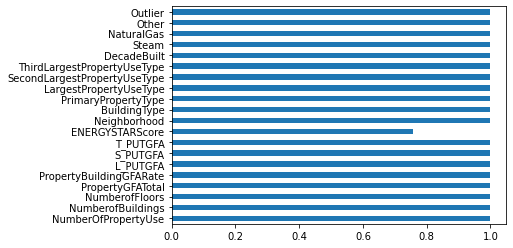

In [245]:
X_raw = pickle.load(open("Data/X.pickle", "rb"))
X_raw.notnull().mean().plot.barh()
plt.show()

En vue de nos modélisations avec elle, plutôt que de diminuer notre échantillon de données en nous séparant des observations dont sa valeur serait nulle, nous avions imputé sa valeur médiane à ses valeurs manquantes.

En utilisant trois estimateurs, **ridge**, **random forest**, et **gradient boosting**, nous allons d'abord regarder des indicateurs nous renseignant sur l'importance de cette variable.<br>Nous regarderons ensuite si se passer d'elle améliore ou détériore nos modélisations.

### **Régression ridge**

In [81]:
# Rappel des résultats avec ESS
liste, mod = modelize(Ridge(), "regression ridge", X, y, True)
liste

{'Model': 'regression ridge',
 'Fit_Time': 0.0870046615600586,
 'Score_time': 0.03500247001647949,
 'MAE': 0.3315054101178619,
 'RMSLE': 0.03167185865883354,
 'R2': 0.8189374960278606}

### Graph des **coefs** du modèle

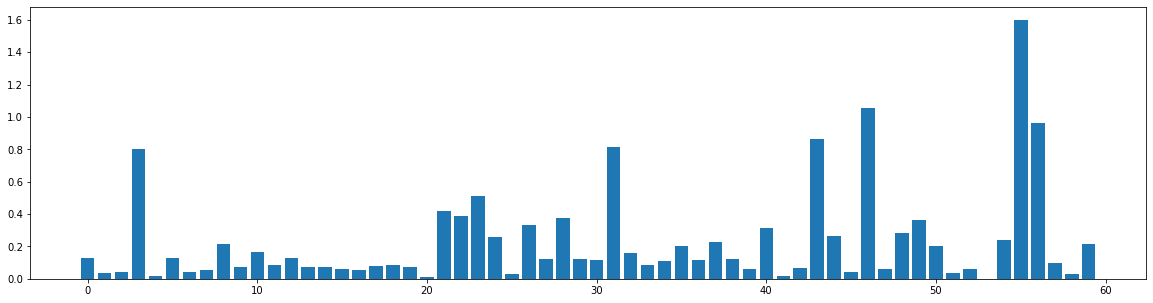

In [248]:
importance = pd.Series(mod.coef_, range(len(mod.coef_)))
fig = plt.figure(figsize = (20,5))
plt.bar(importance.index[:60], np.abs(importance.values)[:60])
plt.show()

Même modélisation sans la variable **ENERGYSTARScore**

In [83]:
X_ses = X.drop("ENERGYSTARScore", axis = 1)

In [84]:
# résultats sabs ESS
liste, mod = modelize(Ridge(), "regression ridge", X_ses, y, True)
liste

{'Model': 'regression ridge',
 'Fit_Time': 0.0760042667388916,
 'Score_time': 0.024001598358154297,
 'MAE': 0.3708046712120974,
 'RMSLE': 0.034419336649194415,
 'R2': 0.7853735420109292}

Les résultats sont sensiblement moins bons...

### **Random forest**

In [85]:
liste, mod = modelize(RandomForestRegressor(random_state = SEED), "random forest reg", X, y, True)
liste

{'Model': 'random forest reg',
 'Fit_Time': 12.780729532241821,
 'Score_time': 0.1150059700012207,
 'MAE': 0.3372207674800788,
 'RMSLE': 0.03363469478370986,
 'R2': 0.7940652368731562}

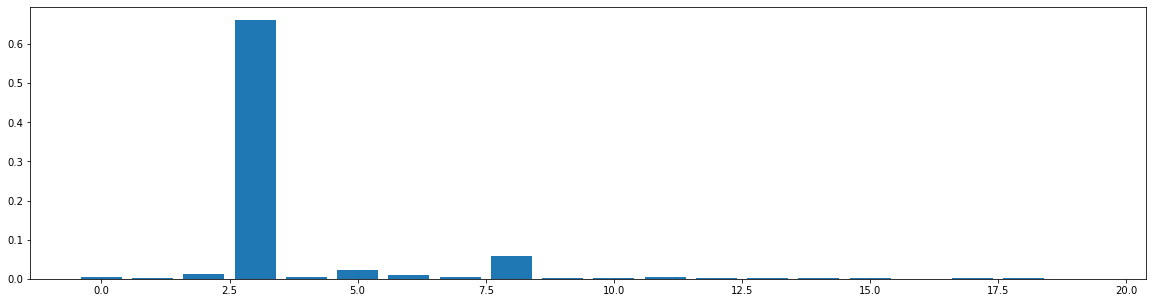

In [255]:
importance = pd.Series(mod.feature_importances_, 
                       range(len(mod.feature_importances_)))
fig = plt.figure(figsize = (20,5))
plt.bar(importance.index[:20], np.abs(importance.values)[:20])
plt.show()

In [10]:
mod.feature_importances_[8]

0.05932260267170293

Avec un estimateur RF, l'importance de l'ESS peut être quantifiée à **5,9 %**.

In [86]:
liste, mod = modelize(RandomForestRegressor(random_state = SEED), "random forest reg", X_ses, y, True)
liste

{'Model': 'random forest reg',
 'Fit_Time': 12.530714273452759,
 'Score_time': 0.11900687217712402,
 'MAE': 0.38735340374321897,
 'RMSLE': 0.03726942344804566,
 'R2': 0.7480258691539852}

Là encore les résultats sont moins bons...

### **xgboost**

In [87]:
liste, mod = modelize(xgboost.XGBRegressor(random_state = SEED), "XGBoost", X, y, True)
liste

{'Model': 'XGBoost',
 'Fit_Time': 2.2141263484954834,
 'Score_time': 0.0630037784576416,
 'MAE': 0.31615174162161275,
 'RMSLE': 0.03119492739420952,
 'R2': 0.8236544069017133}

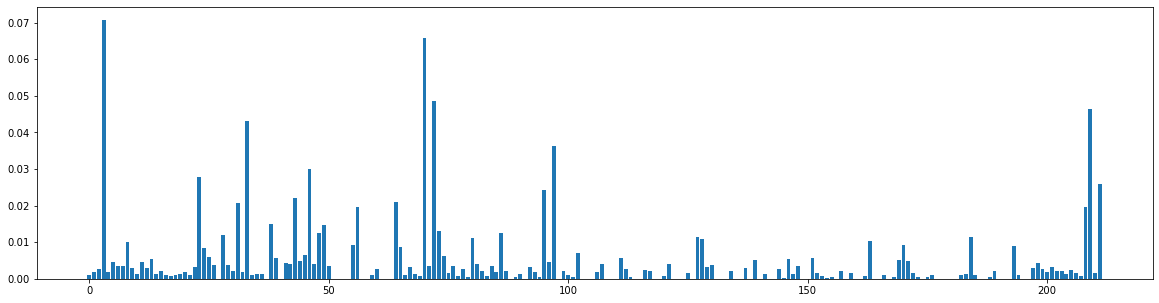

In [260]:
fig = plt.figure(figsize = (20,5))
plt.bar(range(len(mod.feature_importances_)), mod.feature_importances_)
plt.show()

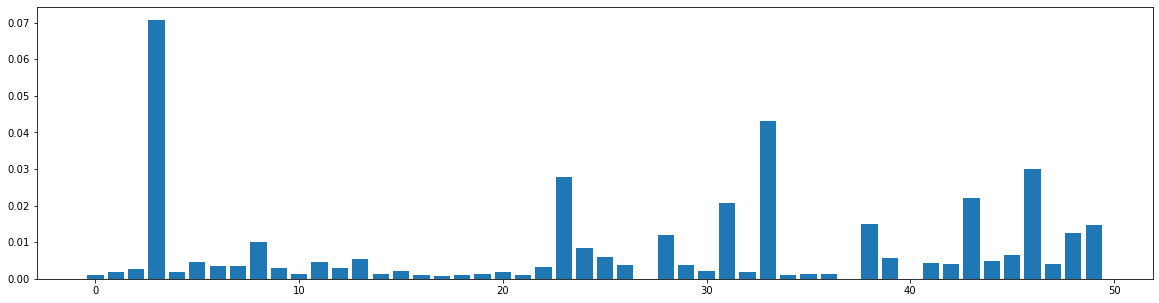

In [261]:
# zoom
fig = plt.figure(figsize = (20,5))
plt.bar(range(len(mod.feature_importances_[:50])), mod.feature_importances_[:50])
plt.show()

In [264]:
mod.feature_importances_[8]

0.01000348

Avec XGBoost, l'indicateur compte pour **1%**.

In [88]:
liste, mod = modelize(xgboost.XGBRegressor(random_state = SEED), "XGBoost", X_ses, y, True)
liste

{'Model': 'XGBoost',
 'Fit_Time': 2.1351218223571777,
 'Score_time': 0.06400370597839355,
 'MAE': 0.3769052191009289,
 'RMSLE': 0.03559620597237821,
 'R2': 0.7712276082184132}

Ici aussi, se passer de la variable **EnergyStarScore** diminue la qualité de la modélisation.

## 5) - Modélisation encodage **Label Encoding**

Ce type d'encodage réduit la complexité des modèles, donc sa variance, mais augmente aussi son biais en modifiant l'information portée par les variables catégorielles, notamment en les transformant en variables ordinales.

On va encoder nos données en amont du pipeline qui devra être aussi modifié...

In [89]:
X_lab = pickle.load(open("Data/X.pickle", "rb"))

X_lab = num_imput(X_lab)
X_lab = num_trans(X_lab)

cat_feat = np.array(X_lab.columns[X_lab.dtypes == "category"])

for cat in cat_feat :
    lab_enc = LabelEncoder()
    X_lab[cat] = lab_enc.fit_transform(X_lab[cat])

In [90]:
df_res_lab = pd.DataFrame(columns = LISTE_COL)

for name, model in d_mod.items():
    
    df_res_lab = df_res_lab.append(modelize(model, name, X_lab, y), ignore_index = True)
    
df_res_lab

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.020001,0.017001,0.398173,0.037548,0.741061
1,Ridge_Reg,0.018001,0.015001,0.398118,0.037548,0.741067
2,Lasso_Reg,0.018001,0.012001,0.891936,0.071994,-0.000587
3,SV_Reg,1.285073,0.210011,0.418859,0.039914,0.705016
4,DT_Reg,0.094006,0.014000,0.491527,0.048415,0.573796
5,RF_Reg,5.692326,0.096006,0.346239,0.034558,0.781744
6,Adaboost_Reg,0.911052,0.044003,0.500670,0.042591,0.661995
7,Bagging_Reg,0.593034,0.026001,0.373430,0.036294,0.758624
8,GB_Reg,1.625092,0.017001,0.328904,0.031906,0.814005
9,XGB_Reg,0.505029,0.024001,0.324810,0.031434,0.819108


Résultats un peu moins bons que les résultats initiaux.<br>Comme on pouvait s'y attendre, les estimateurs linéaires sont plus impactés car pour eux, la transformation certaines des données catégorielles prennent une **connotation ordinale** qui détériore les données.

## 6) - Modélisation encodage **Target Encoding**

Le Target encoding consiste à remplacer les catégories d'une variable par la moyenne des valeurs cibles correspondantes.

In [91]:
X_tar = pickle.load(open("Data/X.pickle", "rb"))

X_tar = num_imput(X_tar)
X_tar = num_trans(X_tar)

cat_feat = np.array(X_tar.columns[X_tar.dtypes == "category"])

for cat in cat_feat :
    tar_enc = TargetEncoder()
    X_tar[cat] = tar_enc.fit_transform(X_tar[cat], y)

e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

In [92]:
df_res_tar = pd.DataFrame(columns = LISTE_COL)

for name, model in d_mod.items():
    
    df_res_tar = df_res_tar.append(modelize(model, name, X_tar, y), ignore_index = True)
    
df_res_tar

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.020001,0.016001,0.348414,0.033181,0.800804
1,Ridge_Reg,0.018001,0.014000,0.348322,0.033180,0.800819
2,Lasso_Reg,0.014000,0.012001,0.892718,0.072055,-0.002240
3,SV_Reg,1.197069,0.193011,0.359050,0.034426,0.786175
4,DT_Reg,0.095005,0.011000,0.454060,0.044738,0.640698
5,RF_Reg,5.569317,0.095006,0.322909,0.031753,0.817204
6,Adaboost_Reg,0.909052,0.040002,0.427782,0.037556,0.739301
7,Bagging_Reg,0.580033,0.023002,0.340522,0.032872,0.803054
8,GB_Reg,1.628093,0.017000,0.313794,0.030254,0.834044
9,XGB_Reg,0.593034,0.022001,0.319759,0.031134,0.824803


Le Target Encoding nous permet d'obtenir une amélioration de nos modèles notamment avec le **Random Forest** et le **Gradient Boosting**.

## 7) - **Sélection** des meilleurs estimateurs

Suite à nos précédents résultats, nous décidons, en vue de la suite, de garder les models les plus prometteurs :<br>- ridge + OHE<br>- svr + OHE<br>- RF + TE<br>- GB + TE

## 8) - **Réduction dimensionnelle** "*expérimentale*"

### Utilisation de la fonction **Optimize_Level**

Il s'agit d'un script fonctionnant en "force brute" qui peut permettre de diminuer le "level" (le nombre de valeurs différentes...) des variables catégorielles si cela augmente les performances des modèles.

In [10]:
# En fonction d'un level "n", et d'une colonne "col" (d'une variable catégorielle) d'un DF "df", 
# cette méthode renvoie une colonne "col" réduite à "n" différentes valeurs. le surplus est
# remplacé par "No_Data" ou des "0"

def level_n_reductor(n, df, col):
    
    df1 = df.copy()
    
    top = df1[col].value_counts().index.tolist()[:n]

    labels = df1[col].value_counts().index.tolist()
    
    type_data = type(labels[0])
    
    if type_data is str :
    
        new = [l if l in top else "No_Data" for l in labels]
    
    else :
        
        new = [l if l in top else 0 for l in labels]
    
    dico = {k:v for k, v in zip(labels, new)}
    
    df1[col] = df1[col].map(dico)
    #df1[col] = df1[col].map(dico).astype("category")
    
    nb = df1[col].unique().shape[0]
    
    return df1, nb



# modélisation renvoyant les résultats dans la métrique "key"

def modeli(n, model, X, y, key) :
        
    resultats = [n]
    
    kf = KFold(K, shuffle = True, random_state = SEED)
    
    cv_res = cross_validate(model, X, y, scoring = SCORING, cv = kf)
    
    dict_metrics = {"MAE" : -cv_res['test_neg_mean_absolute_error'].mean(), 
                    "RMSLE" : np.sqrt(-cv_res['test_neg_mean_squared_log_error']).mean(), 
                    "R2" : cv_res['test_r2'].mean()}
    
    resultats.append(dict_metrics[key])
#     if np.isnan(dict_metrics[key]) :
#         print("NAN !!!")
#         print(model.fit_transform(X))
    
    return resultats


# Pour un df, un model, et une métrique donnés, cette méthode cherche le meilleur level de chaque
# variable catégorielle en allant de la varcat la PLUS PROFONDE à la MOINS PROFONDE.

def optimize_level(model, model_name, df, y, key, encode = "One_Hot"):
    
    X = df.copy()

    # init de listes
    liste = []
    liste_best = []
    liste_X_trans = []
    liste_indice = []
    
    # listage des var cat d'un DF
    liste_var_cat = X.select_dtypes(include="category").columns.to_list()
    
    # création d'une série (classé decroi.) de ces varcat avec leur level en index
    s = pd.Series([k for k in liste_var_cat], 
                  index = [X[var].unique().shape[0] for var in liste_var_cat]).sort_index(ascending = False)

    # boucle dans la série    
    for col, n in zip(s.values, s.index) :

        #print(f"On est dans col - {col} - qui a - {n} - val.")

        # init de listes
        liste_X = []
        liste_n = []

        # pour la colonne col, on crée une liste de df ou col a son level diminué de n à 1
        for i in range(n, 0, -1) : # yo +1

            liste_X.append(level_n_reductor(i, X, col)[0])
            liste_n.append(level_n_reductor(i, X, col)[1])

        liste_b = []
        i = 0
        
        # ensuite on calcul le score pour chaque df
        for df, nb in zip(liste_X, liste_n) :
            
            df1 = df.copy()
            
            if encode == "One_Hot":
                
                df1 = pd.get_dummies(df1, drop_first = True)
            
            else :
                
                cat_feat = np.array(df1.columns[(df1.dtypes == "category")|(df1.dtypes == "object")])

                for cat in cat_feat :
                    tar_enc = TargetEncoder().fit(df1[cat], y)
                    df1[cat] = tar_enc.transform(df1[cat])
            
            liste_b.append([i] + list(modeli(nb, model, df1, y, key))) #yoooo +1
            if i == 0:
                print(f"Score de départ pour la variable {col} : {liste_b[0][2]}")
            
            
            i += 1

        # on récupère meileur score et meilleur indice n correspondant
        ar_b = np.array(liste_b)
        
        if key == "RMSLE" :
            
            best = np.min(ar_b, axis = 0)[2]
            ind = np.argmin(ar_b, axis = 0)[2]
        
        else :
            
            best = np.max(ar_b, axis = 0)[2]
            ind = np.argmax(ar_b, axis = 0)[2] 
        
        best_n = int(ar_b[ind][1])
        
        liste.append(liste_b)
        liste_best.append((i, ind, best, best_n))
        liste_indice.append(best_n)
        
        print(f"Score optimisé à : {best}")
        print()
        
        X = liste_X[ind]
        liste_X_trans.append(X)
        
    # sortie de la boucle, on va drop les varcat devenues cstabaissées à un elem et tou mettre en dtype cat    
    #print("post-traitement")
    
    X_opti = liste_X_trans[-1]
    
    #print(liste_best)
    
    for col in liste_var_cat :
            
        if X_opti[col].dtype.name != "category" :

            X_opti[col] = X_opti[col].astype("category")  
    
    #drop = False
    
    for col in liste_var_cat :

        #print(X_opti[col].dtype, " - ", X_opti[col].dtype.name)

        #print(X_opti[col].unique().shape[0])
        if X_opti[col].unique().shape[0] == 1 :

            #print(f"On drop la colonne : {col}")
            X_opti = X_opti.drop(col, axis = 1)
            #drop = True
    
#     if drop :
#         #print(X_opti.info())
#         liste_best.append(list(modeli("Score apres drop", model, X_opti, y, key)))
    
    #liste_resultats = [model_name, liste_indice, liste_best[-1][2]]
    
    # on retourne les meilleurs score et indice, ainsi que le df ainsi "optimisé"
    #return liste_best, liste_X_trans[-1]
    return liste_best, model_name, liste_best[-1][2], X_opti

### Optimisation **Ridge** et **SVR**

On procède avec les estimateurs **ridge** et **SVR** combinés à un encodage **One Hot**.

In [94]:
X = pickle.load(open("Data/X.pickle", "rb"))
X = num_imput(X)
X = num_trans(X)

red_level_ohe = []

select_mod_ohe = {"Ridge_Reg" : Ridge(),
                  "SV_Reg" : SVR()}

In [95]:
for name, mod in select_mod_ohe.items() :
#for name, mod in zip(modz.keys()[:2], modz.values()[:2]) :
    start = time()
    print()
    print(f"Optimisation du dataset pour le modèle {name}")
    print()
    red_level_ohe.append(optimize_level(mod, name, X, y, "RMSLE"))
    print(f"Meilleur score obtenu : {red_level_ohe[-1][2]}")
    #print(red_level_ohe[-1][1], red_level_ohe[-1][2])
    print(f"on a mis {time() - start} secondes")
    print()

for l in red_level_ohe :
    
    print(l[1], l[2], f"{len(X.columns) - len(l[3].columns)} colonne(s) drop")
    
pickle_out = open("Data/red_level_ohe.pickle", "wb")
pickle.dump(red_level_ohe, pickle_out)
pickle_out.close()


Optimisation du dataset pour le modèle Ridge_Reg

Score de départ pour la variable LargestPropertyUseType : 0.03167185865883354
Score optimisé à : 0.0316513631652541

Score de départ pour la variable SecondLargestPropertyUseType : 0.0316513631652541
Score optimisé à : 0.031604129850779206

Score de départ pour la variable ThirdLargestPropertyUseType : 0.031604129850779206
Score optimisé à : 0.03151377634530807

Score de départ pour la variable PrimaryPropertyType : 0.03151377634530807
Score optimisé à : 0.03151377634530807

Score de départ pour la variable Neighborhood : 0.03151377634530807
Score optimisé à : 0.03148672801841493

Score de départ pour la variable DecadeBuilt : 0.03148672801841493
Score optimisé à : 0.03148672801841493

Score de départ pour la variable BuildingType : 0.03148672801841493
Score optimisé à : 0.031461881754527535

Score de départ pour la variable Steam : 0.031461881754527535
Score optimisé à : 0.031461881754527535

Score de départ pour la variable NaturalGa

### Optimisation **Random Forest** et **Gradient Boosting**

**RF** et **GB** avec encodage **Target Encoding**

In [98]:
X = pickle.load(open("Data/X.pickle", "rb"))
X = num_imput(X)
X = num_trans(X)

red_level_tar = []

select_mod_tar = {"RF_Reg" : RandomForestRegressor(random_state = SEED),
                  "GB_Reg" : GradientBoostingRegressor(random_state = SEED)}

In [99]:
for name, mod in select_mod_tar.items() :
#for name, mod in zip(modz.keys()[:2], modz.values()[:2]) :
    start = time()
    print(f"Optimisation du dataset pour le modèle {name}")
    print()
    red_level_tar.append(optimize_level(mod, name, X, y, "RMSLE", "Target"))
    print(f"Meilleur score obtenu : {red_level_tar[-1][2]}")
    print(f"on a mis {time() - start} secondes")
    print()

for l in red_level_tar :
    
    print(l[1], l[2], f"{len(X.columns) - len(l[3].columns)} colonne(s) drop")
    
pickle_out = open("Data/red_level_tar.pickle", "wb")
pickle.dump(red_level_tar, pickle_out)
pickle_out.close()

Optimisation du dataset pour le modèle RF_Reg



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable LargestPropertyUseType : 0.03175258001183985


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03166440917333148



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable SecondLargestPropertyUseType : 0.03166440917333148


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.031603658313740006



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable ThirdLargestPropertyUseType : 0.031603658313740006


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03158889695751277



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable PrimaryPropertyType : 0.03158889695751277


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03147256973084162



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Neighborhood : 0.03147256973084162


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03146951605938926



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable DecadeBuilt : 0.03146951605938926


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03146951605938926



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable BuildingType : 0.03146951605938926


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03140285375256986



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Steam : 0.03140285375256986


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03140285375256986



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable NaturalGas : 0.03140285375256986


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03140285375256986



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Other : 0.03140285375256986


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03140285375256986



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Outlier : 0.03140285375256986


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.03140285375256986

Meilleur score obtenu : 0.03140285375256986
on a mis 1272.7896041870117 secondes

Optimisation du dataset pour le modèle GB_Reg



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable LargestPropertyUseType : 0.03025391898985349


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.030178174429063336



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable SecondLargestPropertyUseType : 0.030178174429063336


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.030178174429063325



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable ThirdLargestPropertyUseType : 0.030178174429063325


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.030151711493947003



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable PrimaryPropertyType : 0.030151711493947003


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.030026786611984484



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Neighborhood : 0.030026786611984484


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.02997522261547637



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable DecadeBuilt : 0.02997522261547637


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.02997522261547637



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable BuildingType : 0.02997522261547637


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.02997522261547637



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Steam : 0.02997522261547637


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.02997522261547637



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable NaturalGas : 0.02997522261547637


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.02997522261547637



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Other : 0.02997522261547637


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.02996878522902069



e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score de départ pour la variable Outlier : 0.02996878522902069


e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

Score optimisé à : 0.02996878522902069

Meilleur score obtenu : 0.02996878522902069
on a mis 386.12401056289673 secondes

RF_Reg 0.03140285375256986 0 colonne(s) drop
GB_Reg 0.02996878522902069 1 colonne(s) drop


**NDLR** : La cellule présentant les résultats de cette seconde partie d'optimisation est désactivée en raison d'une *invasion de messages d'avertissement*.<br>Les résultats obtenus et sauvegardés sont les suivants :

A partir demaintenant, suite à cette "optimisation", chaque estimateur aura son **propre dataset optimisé associé**.

In [102]:
liste_ohe = pickle.load(open("Data/red_level_ohe.pickle", "rb"))
liste_tar = pickle.load(open("Data/red_level_tar.pickle", "rb"))

In [103]:
X_ridge = liste_ohe[0][3]
X_svr = liste_ohe[1][3]
X_rf = liste_tar[0][3]
X_gb = liste_tar[1][3]

## 9) - Encodage définitif des datasets

In [104]:
# preprocessing X_ridge et X_svr avec encodage OHE
X_ridge_ohe = cat_trans(X_ridge)
X_svr_ohe = cat_trans(X_svr)

In [105]:
# preprocessing X_rf avec encodage Target Encoding

X_rf_te = X_rf.copy()

cat_feat = np.array(X_rf_te.columns[X_rf_te.dtypes == "category"])

for cat in cat_feat :
    tar_enc = TargetEncoder()
    X_rf_te[cat] = tar_enc.fit_transform(X_rf_te[cat], y)

# preprocessing X_gb avec encodage Target Encoding

X_gb_te = X_gb.copy()

cat_feat = np.array(X_gb_te.columns[X_gb_te.dtypes == "category"])

for cat in cat_feat :
    tar_enc = TargetEncoder()
    X_gb_te[cat] = tar_enc.fit_transform(X_gb_te[cat], y)

e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
e:\anaconda3\envs\OpClass\lib\site-packages\category_enc

## 10) - Feature Sélection avec **RFECV**

In [ ]:
explication...

### RFECV **Ridge**

In [107]:
selector_ri = RFECV(estimator = Ridge(),
                    scoring = 'neg_mean_squared_log_error',
                    cv = KFold(K, shuffle = True, random_state = SEED),
                    step = 1)

X_ridge_rfe = selector_ri.fit_transform(X_ridge_ohe, y)

print(selector_ri.ranking_)
print(X_ridge_ohe.shape)
print(X_ridge_rfe.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(3303, 144)
(3303, 144)


Pas d'amélioration obtenue...

### RFEVC **SVR** (à kernel linéaire)

On doit utiliser un estimateur disposant des attributs "coeff_" ou "feature_importances_", du coup on utilise une SVR à **noyau linéaire**.<br>On vérifiera néanmoins ensuite que la réduction éventuelle proposée se traduira par une amélioration du modèle à kernel **rbf**.

In [108]:
selector_sv = RFECV(estimator=SVR(kernel = "linear"),
                    scoring='neg_mean_squared_log_error',
                    cv = KFold(K, shuffle = True, random_state = SEED),
                    step = 1)

X_svr_rfe = selector_sv.fit_transform(X_svr_ohe, y)

print(selector_sv.ranking_)
#print(np.sqrt(-selector_sv.grid_scores_))
print(X_svr_ohe.shape)
print(X_svr_rfe.shape)

[ 1  1  1  1  1  1  1  1  1  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  3  1 11  1  1  1  1  1  4  1  1  1  1  1  1  1  7  9  1  1  1  1  1
  1  1  1  2  6  1  1  1  1  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1]
(3303, 145)
(3303, 135)


In [109]:
modelize(SVR(), "svr_rfe", X_svr_rfe, y)

{'Model': 'svr_rfe',
 'Fit_Time': 3.639207601547241,
 'Score_time': 0.718040943145752,
 'MAE': 0.31294273257086813,
 'RMSLE': 0.03154439131913981,
 'R2': 0.8163178001065958}

Amélioration du résultat et réduction de **10 colonnes**.

### RFECV **Random Forest**

In [110]:
selector_rf = RFECV(estimator = RandomForestRegressor(random_state = SEED),
                    scoring='neg_mean_squared_log_error',
                    cv = KFold(K, shuffle = True, random_state = SEED),
                    step = 1)

X_rf_rfe = selector_rf.fit_transform(X_rf_te, y)

print(selector_rf.ranking_)
#print(selector_rf.grid_scores_)
print(X_rf_te.shape)
print(X_rf_rfe.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(3303, 20)
(3303, 20)


Pas d'amélioration

### RFECV **GB**

In [111]:
selector_gb = RFECV(estimator=GradientBoostingRegressor(random_state = SEED),
                 scoring='neg_mean_squared_log_error',
                 cv = KFold(K, shuffle = True, random_state = SEED),
                 step = 1)

X_gb_rfe = selector_gb.fit_transform(X_gb_te, y)

print(selector_gb.ranking_)
#print(np.sqrt(-selector_gb.grid_scores_))
print(X_gb_te.shape)
print(X_gb_rfe.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(3303, 19)
(3303, 19)


Là encore, pas d'amélioration.

In [112]:
liste_X_post_rfe = [X_ridge_rfe, X_svr_rfe, X_rf_rfe, X_gb_rfe]

In [113]:
pickle_out = open("Data/liste_X_post_rfe.pickle", "wb")
pickle.dump(liste_X_post_rfe, pickle_out)
pickle_out.close()

In [114]:
liste = pickle.load(open("Data/liste_X_post_rfe.pickle", "rb"))

X_ridge_rfe = liste[0]
X_svr_rfe = liste[1]
X_rf_rfe = liste[2]
X_gb_rfe = liste[3]

## 11) - Feature Selection avec **SelectPercentile**

Pour chaque dataset correspondant à un de nos estimateurs npous allons pratiquer le test **f_regression**, qui donnera un *score de linéarité* de chaque variable avec la cible.<br>A partir de là, grâce à **SelectPercentile**, nous verrons si on améliore nos modèles en nous passant éventuellement des "**x%** *moins bonnes variables*".

### **Ridge**

In [115]:
f_regression(X_ridge_rfe, y)

(array([2.65517529e+02, 1.10992885e+02, 5.79381180e+02, 5.65966636e+03,
        2.61984600e+02, 2.93728877e+01, 1.27410627e+02, 5.42943280e+01,
        1.01249224e+02, 3.65765900e-01, 1.60867233e+02, 5.41474587e+02,
        1.01211956e-01, 6.36583928e+01, 1.76542640e+02, 5.65773479e+00,
        1.14273764e+02, 1.02850842e+02, 8.47065484e+01, 2.82476567e+00,
        4.07312463e+01, 4.78387830e+02, 5.66815857e+02, 3.71573255e+01,
        4.70928066e-01, 1.33008472e+01, 2.22263333e-01, 5.43782528e+01,
        5.22665405e-02, 2.30427813e-01, 4.09256756e+00, 1.30069268e+00,
        3.20944085e+01, 3.77961378e+01, 2.72250885e+00, 6.49260585e+01,
        1.61081497e+01, 5.53883618e+01, 3.80158069e+01, 6.57938742e-01,
        1.61081497e+01, 2.31144204e+01, 1.01000425e+01, 3.38099248e-01,
        2.42157497e+00, 1.02850842e+02, 8.64093467e+01, 2.82476567e+00,
        4.83191749e+01, 8.80873583e-02, 6.97371954e+00, 6.84502174e-01,
        3.78477997e+01, 3.14443453e+02, 1.46494243e+00, 9.535243

Graph représentant les résultats du test **f_regression** entre chaque variable et notre cible.

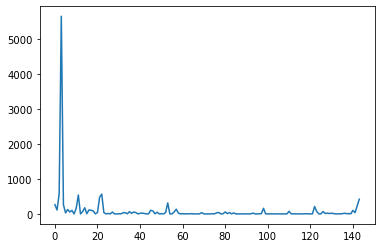

In [116]:
plt.plot(f_regression(X_ridge_rfe, y)[0])
plt.show()

In [118]:
df_perc_ridge = pd.DataFrame(columns = ["p"] + LISTE_COL )

for p in range(0, 101) :
    
    selector_ri = SelectPercentile(f_regression, p)
    X_ridge_perc = selector_ri.fit_transform(X_ridge_rfe, y)
    df_perc_ridge = df_perc_ridge.append(dict({"p" : p}, **modelize(Ridge(), "Ridge", X_ridge_perc, y)), ignore_index = True)
    
#df_perc_ridge.sort_values("RMSLE")[:5]

e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\feature_selection\_base.py:79: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\linear_

In [119]:
df_perc_ridge.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
83,83,Ridge,0.024001,0.005000,0.326890,0.031411,0.822415
84,84,Ridge,0.027001,0.006001,0.327144,0.031420,0.822337
77,77,Ridge,0.027002,0.007000,0.326345,0.031431,0.822165
75,75,Ridge,0.025001,0.005001,0.326373,0.031432,0.822150
74,74,Ridge,0.021001,0.008000,0.326301,0.031434,0.822120


La meilleure configuration est celle ne gardant que les **83%** meilleures variables selon le test **f_regression**.

In [121]:
X_ridge_perc = SelectPercentile(f_regression, 83).fit_transform(X_ridge_rfe, y)

e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=83 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [122]:
X_ridge_perc.shape

(3303, 119)

Cette procédure nous aura permis une légère amélioration des résultats et une réduction dimensionnelle de 144 à 119 variables, doit une diminution de **25** colonnes.

### **SVR**

In [124]:
f_regression(X_svr_rfe, y)

(array([2.65517529e+02, 1.10992885e+02, 5.79381180e+02, 5.65966636e+03,
        2.61984600e+02, 2.93728877e+01, 1.27410627e+02, 5.42943280e+01,
        1.01249224e+02, 1.32550353e+02, 5.41474587e+02, 1.01211956e-01,
        1.76542640e+02, 1.93935580e+01, 5.65773479e+00, 1.14273764e+02,
        8.47065484e+01, 2.82476567e+00, 4.78387830e+02, 5.66815857e+02,
        3.71573255e+01, 4.70928066e-01, 1.33008472e+01, 7.26289064e+01,
        5.43782528e+01, 2.30427813e-01, 1.30069268e+00, 3.20944085e+01,
        3.77961378e+01, 2.72250885e+00, 6.49260585e+01, 1.61081497e+01,
        5.53883618e+01, 3.80158069e+01, 1.61081497e+01, 1.01000425e+01,
        2.42157497e+00, 1.02850842e+02, 8.64093467e+01, 2.82476567e+00,
        4.83191749e+01, 6.84502174e-01, 3.78477997e+01, 3.14443453e+02,
        1.46494243e+00, 1.95338791e+01, 5.42597104e+01, 1.35262772e+02,
        2.19937003e+01, 7.24384367e+00, 2.36134296e-01, 7.96313043e+00,
        5.03043364e-01, 3.61714276e+01, 5.22665405e-02, 1.614181

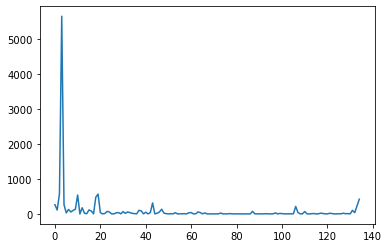

In [125]:
plt.plot(f_regression(X_svr_rfe, y)[0])
plt.show()

In [126]:
df_perc_svr = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector_sv = SelectPercentile(f_regression, p)
    X_svr_perc = selector_sv.fit_transform(X_svr_rfe, y)
    df_perc_svr = df_perc_svr.append(dict({"p" : p}, **modelize(SVR(), "SVR", X_svr_perc, y)), 
                                     ignore_index = True)

e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=51 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=53 as keyword args. From version 0.25 passing these as positional arguments will resul

In [127]:
df_perc_svr.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
50,100,SVR,3.694211,0.722041,0.312943,0.031544,0.816318
49,99,SVR,3.625207,0.711041,0.313812,0.031600,0.815767
48,98,SVR,3.632206,0.707041,0.313828,0.031602,0.815748
47,97,SVR,3.536202,0.699040,0.313951,0.031616,0.815578
43,93,SVR,3.471199,0.674038,0.313660,0.031639,0.815274


Pas d'améliorations puisque le meilleur résultat est lorsque qu'on garde **100%** des variables.

In [128]:
X_svr_perc = X_svr_rfe

### **Random Forest**

In [129]:
f_regression(X_rf_rfe, y)

(array([ 265.51752891,  110.99288456,  579.3811798 , 5659.66636099,
         261.98460049,   29.37288766,  127.41062655,   54.29432797,
         101.24922442,  341.55086205,  176.54264   , 2209.00684885,
        1230.01430561,  255.17049415,  331.07486137,  181.73316279,
         225.75973852,  422.19720153,   10.37241879,  617.10591766]),
 array([1.77892417e-057, 1.50368150e-025, 4.38582639e-118, 0.00000000e+000,
        9.18826436e-057, 6.39932834e-008, 5.10391614e-029, 2.17000945e-013,
        1.76212380e-023, 1.20157894e-072, 2.76444240e-039, 0.00000000e+000,
        2.50755248e-229, 2.19116430e-055, 1.41368415e-070, 2.32603755e-040,
        2.08019880e-049, 2.19673375e-088, 1.29153245e-003, 4.95973045e-125]))

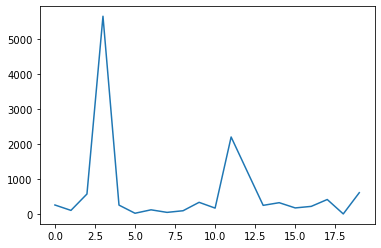

In [130]:
plt.plot(f_regression(X_rf_rfe, y)[0])
plt.show()

In [131]:
df_perc_rf = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector_rf = SelectPercentile(f_regression, p)
    X_rf_perc = selector_rf.fit_transform(X_rf_rfe, y)
    df_perc_rf = df_perc_rf.append(dict({"p" : p}, 
                                        **modelize(RandomForestRegressor(random_state = SEED),
                                                   "Random Forest", X_rf_perc, y)), 
                                   ignore_index = True)

e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=51 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=53 as keyword args. From version 0.25 passing these as positional arguments will resul

In [132]:
df_perc_rf.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
50,100,Random Forest,5.614321,0.089005,0.320850,0.031403,0.820721
48,98,Random Forest,5.565318,0.087005,0.320231,0.031422,0.820571
47,97,Random Forest,5.488315,0.091005,0.320231,0.031422,0.820571
46,96,Random Forest,5.429311,0.087005,0.320231,0.031422,0.820571
45,95,Random Forest,5.408309,0.087005,0.320231,0.031422,0.820571


Là encore, aucune amélioration, ce qui est moins étonnant étant donné la quantité moindre de variables ici.

In [133]:
X_rf_perc = X_rf_rfe

### **Gradient Boosting**

In [134]:
f_regression(X_gb_rfe, y)

(array([ 265.51752891,  110.99288456,  579.3811798 , 5659.66636099,
         261.98460049,   29.37288766,  127.41062655,   54.29432797,
         101.24922442,  339.54242763,  774.59262591,  642.62956192,
        1230.01430561,  255.92149756,  309.71079499,  181.73316279,
         225.75973852,  422.19720153,  617.10591766]),
 array([1.77892417e-057, 1.50368150e-025, 4.38582639e-118, 0.00000000e+000,
        9.18826436e-057, 6.39932834e-008, 5.10391614e-029, 2.17000945e-013,
        1.76212380e-023, 2.99396414e-072, 2.55364338e-153, 1.08089108e-129,
        2.50755248e-229, 1.54428256e-055, 2.46712764e-066, 2.32603755e-040,
        2.08019880e-049, 2.19673375e-088, 4.95973045e-125]))

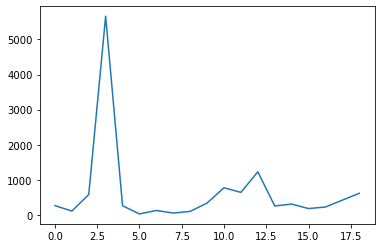

In [135]:
plt.plot(f_regression(X_gb_rfe, y)[0])
plt.show()

In [136]:
df_perc_gb = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector_gb = SelectPercentile(f_regression, p)
    X_gb_perc = selector_gb.fit_transform(X_gb_rfe, y)
    df_perc_gb = df_perc_gb.append(dict({"p" : p}, 
                                        **modelize(GradientBoostingRegressor(random_state = SEED),
                                                   "Gradient BoostingB", X_gb_perc, y)), 
                                   ignore_index = True)

e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=51 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
e:\anaconda3\envs\OpClass\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass percentile=53 as keyword args. From version 0.25 passing these as positional arguments will resul

In [141]:
df_perc_gb.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
50,100,Gradient BoostingB,1.587091,0.011000,0.310418,0.029975,0.837548
45,95,Gradient BoostingB,1.427082,0.010000,0.317852,0.030435,0.831703
46,96,Gradient BoostingB,1.414081,0.010000,0.317852,0.030435,0.831703
49,99,Gradient BoostingB,1.422081,0.010001,0.317852,0.030435,0.831703
48,98,Gradient BoostingB,1.412081,0.010001,0.317852,0.030435,0.831703


Pareil que précédemment, aucun gain de performance.

In [142]:
X_gb_perc = X_gb_rfe

Sauvegarde...

In [143]:
liste_X_perc = [X_ridge_perc, X_svr_perc, X_rf_perc, X_gb_perc]

In [144]:
pickle_out = open("Data/liste_X_perc.pickle", "wb")
pickle.dump(liste_X_perc, pickle_out)
pickle_out.close()

## 12) - Hyper Paramétrage avec **GridSearchCV** et **RandomizedSearchCV**

Il s'agit de l'étape finale de notre modélisation, celle de **l'hyper paramétrage** des modèles.<br>Jusqu'à présent, nous n'avons utiliser que des modèles réglés **par défaut** dans notre progression. Maintenant, grâce à **GridSearchCV** et **RandomizedSearchCV** nous allons essayer de trouver les meilleurs réglages possibles de leurs hyper-paramètres.<br><br>Conformement à notre démarche, la métrique qui guidera cette optimisation sera encore la **RMSLE**.

In [176]:
# rechargement des datasets associés aux modèles
liste_X_gs = pickle.load(open("Data/liste_X_perc.pickle", "rb"))

X_ridge_gs = liste_X_gs[0]
X_svr_gs = liste_X_gs[1]
X_rf_gs = liste_X_gs[2]
X_gb_gs = liste_X_gs[3]

# liste des colonnes de nos df de présentations des résultats
LISTE_COL_F = ["Model", "Fit_Time", "Score_time", "MAE", "Std MAE", "RMSLE", "Std RMSLE","R2", 
               "Std R2"]

CV = KFold(K, shuffle = True, random_state = SEED)

Modification de notre fonction de visualisation afin de tenir compte de l'écart-type des résultats de validation croisée.

In [164]:
def modelize_std(model, name, X, y, k = K) :
        
    resultats = []
    
    kf = KFold(k, shuffle = True, random_state = SEED)
    
    try :
        cv_res = cross_validate(model, X, y, scoring = SCORING, cv = kf)

        resultats.append(name)
        resultats.append(cv_res["fit_time"].sum())
        resultats.append(cv_res["score_time"].sum())
        resultats.append(-cv_res['test_neg_mean_absolute_error'].mean())
        resultats.append(f"\u00B1{np.abs(-cv_res['test_neg_mean_absolute_error'].std()):.4f}")
        resultats.append(np.sqrt(-cv_res['test_neg_mean_squared_log_error']).mean())
        resultats.append(f"\u00B1{np.sqrt(-cv_res['test_neg_mean_squared_log_error']).std():.4f}")
        resultats.append(cv_res['test_r2'].mean())
        resultats.append(f"\u00B1{cv_res['test_r2'].std():.4f}")

    except :
        
        pass

    new_row = {k:v for k, v in zip(LISTE_COL_F, resultats)}

    return new_row

## Optimisation **Ridge**

Dans le cas de l'estimateur **Ridge Régression**, il n'y a qu'un seul hyper-paramètre à optimiser, le coefficient de régularisation **alpha**.

In [17]:
# Grille du paramétrage
param_ridge = {"alpha" : np.logspace(0.001, 1, 50)}

# Définition de la recherche
ridge_grid = GridSearchCV(Ridge(), 
                          param_ridge, 
                          scoring = "neg_mean_squared_log_error",
                          cv = CV                         
                         )

Lancement de la recherche

In [19]:
start = time()
ridge_grid.fit(X_ridge_gs, y)
print(f"Temps nécessaire à la recherche : {time()-start} secondes.")

Temps nécessaire à la recherche : 1.561089277267456 secondes.


Nous obtenons le meilleur paramètre **alpha** grâce à l'instruction suivante :

In [10]:
ridge_grid.best_params_

{'alpha': 1.5292898141606428}

Ce qui correspond à ce que nous pouvons observer si nous observons le graph du score en fonction de **alpha** justement...

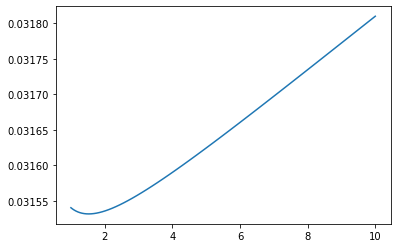

In [11]:
score = np.sqrt(- ridge_grid.cv_results_["mean_test_score"])
plt.plot(np.logspace(0.001, 1, 50), score)
plt.show()

In [12]:
np.sqrt(-max(ridge_grid.cv_results_["mean_test_score"]))

0.03153159130312773

Nous sommes maintenant en mesure d'obtenir le meilleur estimateur **ridge** de la cible **SiteEnergyUse** avec l'instruction suivante :

In [13]:
b_ridge = ridge_grid.best_estimator_

Qui nous donne le résultat suivant :

In [193]:
res_finaux = pd.DataFrame(columns = LISTE_COL_F)
res_finaux = res_finaux.append(modelize_std(b_ridge, "best_ridge", X_ridge_gs, y), 
                               ignore_index = True)
res_finaux

,Model,Fit_Time,Score_time,MAE,Std MAE,RMSLE,Std RMSLE,R2,Std R2
0,best_ridge,0.037002,0.007,0.326486,±0.0175,0.031402,±0.0029,0.822575,±0.0247


Sauvegarde

In [195]:
pickle_out = open("Data/b_ridge.pickle", "wb")
pickle.dump(b_ridge, pickle_out)
pickle_out.close()

## Optimisation **SVR**

Avec un choix de **kernel** fixé sur **"rbf"** et un choix de **gamma** sur **"scale"**, il va s'agir pour nous ici de trouver de bons réglages sur les hyper-paramètres **C** et **epsilon**.

In [177]:
# Grille de paramétrage
param_SVR = {"kernel" : ["rbf"], 
             "gamma" : ["scale"], 
             "C" : [0.1, 1, 10, 20, 100, 1000],
             "epsilon" : [0.01, 0.1, 0.5, 1]
            }

# Définition de la recherche
svr_grid = GridSearchCV(SVR(), 
                        param_SVR, 
                        scoring = "neg_mean_squared_log_error", 
                        cv = CV
                       )

In [178]:
start = time()
svr_grid.fit(X_svr_gs, y)
print(f"Temps nécessaire à la recherche : {time()-start} secondes.")

Temps nécessaire à la recherche : 249.01719784736633 secondes.


Meilleurs paramètres provisoires :

In [179]:
#svr = svr_grid.best_estimator_
svr_grid.best_params_

{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Seconde recherche plus ciblée

In [180]:
# Grille de paramétrage
param_SVR_2 = {"kernel" : ["rbf"], 
             "gamma" : ["scale"], 
             "C" : [0.5, 0.75, 1, 1.25, 1.5, 2, 2.5],
             "epsilon" : [0.05, 0.075, 0.1, 0.125, 0.15]
            }

# Définition de la recherche
svr_grid_2 = GridSearchCV(SVR(),
                          param_SVR_2,
                          scoring = "neg_mean_squared_log_error",
                          cv = CV
                          )

In [181]:
start = time()
svr_grid_2.fit(X_svr_gs, y)
print(f"Temps nécessaire à la recherche : {time()-start} secondes.")

Temps nécessaire à la recherche : 162.81328558921814 secondes.


Meilleurs hyper-paramètres :

In [182]:
svr_grid_2.best_params_

{'C': 2.5, 'epsilon': 0.125, 'gamma': 'scale', 'kernel': 'rbf'}

Test du meilleur modèle **SVR** :

In [194]:
b_svr = svr_grid_2.best_estimator_
res_finaux = res_finaux.append(modelize_std(b_svr, "best_SVR", X_svr_gs, y), 
                               ignore_index = True)
res_finaux

,Model,Fit_Time,Score_time,MAE,Std MAE,RMSLE,Std RMSLE,R2,Std R2
0,best_ridge,0.037002,0.00700,0.326486,±0.0175,0.031402,±0.0029,0.822575,±0.0247
1,best_SVR,3.941225,0.69604,0.310002,±0.0187,0.031113,±0.0033,0.822234,±0.0270


Sauvegarde

In [196]:
pickle_out = open("Data/b_svr.pickle", "wb")
pickle.dump(b_svr, pickle_out)
pickle_out.close()

## Optimisation **Random Forest**

Les algorithme de modélisation **Random Forest** sont assez complexes et disposent de nombreux hyper-paramètres. Nous allons cependant nous concentrer sur 5 d'entre eux :<br>**n_estimators** : le nombre d'arbres de décisions créés<br>**max_depth** : la profondeur max de ces arbres<br>**max_features** :<br>**min_samples_split** :<br>**min_samples_leaf** :

En raison du nombre de combinaisons de paramètres à tester, nous allons dans un premier temps effectuer une recherche ramdomisée avec **RandomizedSearchCV** avant, par la suite d'affiner nos résultats avec une utilisation de **GridSearchCV**.

In [186]:
param_RF_rs = {"n_estimators" : [100, 200, 300, 400, 500, 1000, 1500, 2000, 3000],
            "max_depth" : [2, 3, 4, 5, 10, 15, 20],
            "max_features" : ['auto', 'sqrt'],
            "min_samples_split" : [2, 5, 10, 15],
            "min_samples_leaf" : [1, 2, 3, 5, 10]               
            }


rf_rand = RandomizedSearchCV(RandomForestRegressor(random_state = SEED),
                             param_RF_rs,
                             n_iter = 200,
                             scoring = "neg_mean_squared_log_error",
                             cv = K)

In [187]:
start = time()
rf_rand.fit(X_rf_gs, y)
print(f"Temps nécessaire à la recherche : {time()-start} secondes.")

Temps nécessaire à la recherche : 3395.126095533371 secondes.


In [188]:
rf_rand.best_params_

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 15}

GridSearch plus localisée

In [189]:
param_RF_gs = {"n_estimators" : [250, 300, 350],
               "max_depth" : [13, 14, 15, 16, 17],
               "max_features" : ['auto'],
               "min_samples_split" : [12, 15, 20, 25],
               "min_samples_leaf" : [2]
              }

rf_grid = GridSearchCV(RandomForestRegressor(random_state = SEED),
                       param_RF_gs,
                       scoring = "neg_mean_squared_log_error",
                       cv = CV
                       )

In [190]:
start = time()
rf_grid.fit(X_rf_gs, y)
print(f"Temps nécessaire à la recherche : {time()-start} secondes.")

Temps nécessaire à la recherche : 675.9426620006561 secondes.


In [191]:
rf_grid.best_params_

{'max_depth': 16,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 350}

In [197]:
b_rf = rf_grid.best_estimator_
res_finaux = res_finaux.append(modelize_std(b_rf, "best_RF", X_rf_gs, y), 
                               ignore_index = True)
res_finaux

,Model,Fit_Time,Score_time,MAE,Std MAE,RMSLE,Std RMSLE,R2,Std R2
0,best_ridge,0.037002,0.007000,0.326486,±0.0175,0.031402,±0.0029,0.822575,±0.0247
1,best_SVR,3.941225,0.696040,0.310002,±0.0187,0.031113,±0.0033,0.822234,±0.0270
2,best_RF,13.672782,0.225013,0.320220,±0.0143,0.031332,±0.0030,0.821145,±0.0258


In [ ]:
pickle_out = open("Data/b_rf.pickle", "wb")
pickle.dump(b_rf, pickle_out)
pickle_out.close()

## Optimisation **Gradient Boosting**

Là encore, le modèle est complexe. Nous allons à nouveau commencer par une recherche randomisée qu'on finalisera avec une grille.<br>Les hyper-paramètres que nous allons optimiser sont :

In [205]:
param_gb_rand = {"learning_rate" : [0.05, 0.075, 0.1, 0.125, 0.15],
                 "n_estimators" : [50, 75, 100, 150, 200],
                 "subsample" : [0.8, 0.85, 0.9, 0.95, 1],
                 "max_depth" : [2, 3, 4, 5, 10, 15],
                 "min_samples_split" : [10, 20, 30, 40, 50],
                 "min_samples_leaf" : [5, 10, 20, 30]
                }


gb_rand = RandomizedSearchCV(GradientBoostingRegressor(random_state = SEED),
                             param_gb_rand,
                             n_iter = 400,
                             scoring = "neg_mean_squared_log_error",
                             cv = CV)

In [206]:
start = time()
gb_rand.fit(X_gb_gs, y)
print(f"Temps nécessaire à la recherche : {time()-start} secondes.")

Temps nécessaire à la recherche : 1277.4430632591248 secondes.


In [207]:
gb_rand.best_params_

{'subsample': 0.8,
 'n_estimators': 200,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_depth': 4,
 'learning_rate': 0.15}

GridSearchCV ciblée

In [211]:
param_gb_gs = {"learning_rate" : [0.125, 0.15, 0.175],
               "n_estimators" : [150, 200, 250],
               "subsample" : [0.8],
               "max_depth" : [3, 4, 5],
               "min_samples_split" : [15, 20, 25],
               "min_samples_leaf" : [5, 10, 15]
               }

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state = SEED),
                       param_gb_gs,
                       scoring = "neg_mean_squared_log_error",
                       cv = CV
                      )

In [212]:
start = time()
gb_grid.fit(X_gb_gs, y)
print(f"Temps nécessaire à la recherche : {time()-start} secondes.")

Temps nécessaire à la recherche : 934.5364468097687 secondes.


In [213]:
gb_grid.best_params_

{'learning_rate': 0.125,
 'max_depth': 4,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 200,
 'subsample': 0.8}

In [214]:
b_gb = gb_grid.best_estimator_
res_finaux = res_finaux.append(modelize_std(b_gb, "best_GB", X_gb_gs, y), 
                               ignore_index = True)
res_finaux

,Model,Fit_Time,Score_time,MAE,Std MAE,RMSLE,Std RMSLE,R2,Std R2
0,best_ridge,0.037002,0.007000,0.326486,±0.0175,0.031402,±0.0029,0.822575,±0.0247
1,best_SVR,3.941225,0.696040,0.310002,±0.0187,0.031113,±0.0033,0.822234,±0.0270
2,best_RF,13.672782,0.225013,0.320220,±0.0143,0.031332,±0.0030,0.821145,±0.0258
3,best_GB,3.722213,0.018002,0.300551,±0.0147,0.029001,±0.0025,0.847668,±0.0201


In [215]:
pickle_out = open("Data/b_gb.pickle", "wb")
pickle.dump(b_gb, pickle_out)
pickle_out.close()

Sauvegarde des modèles de la première modélisation

In [221]:
liste_mod_energy = [b_ridge, b_svr, b_rf, b_gb]

In [222]:
pickle_out = open("Data/liste_mod_energy.pickle", "wb")
pickle.dump(liste_mod_energy, pickle_out)
pickle_out.close()

In [ ]:
## Choix du model, avantages/inconvénient

In [ ]:
## interprétation réel

In [ ]:
## influence outliers

In [ ]:
## influence ESS

In [ ]:
## analyse des prediction

In [ ]:
cross_val_predict & voir quelle sont les + mauvaises prediction et s'il y a des caractéristiques qui ressortent

In [ ]:
--> test stat ou correl

In [ ]:
## learning curve voir si on aurait intéret à accumuler plus de data

# Learning Curve

In [176]:
mod_lc = [best_ridge, svr2, rd_xgb]

In [ ]:
fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")

In [198]:
lc_ridge = learning_curve(best_ridge, X, y ,train_sizes = np.linspace(0.05, 1, 20))

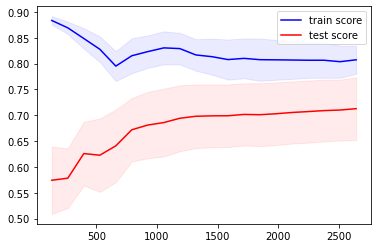

In [207]:
train_scores = lc_ridge[1].mean(axis = 1)
train_std = lc_ridge[1].std(axis = 1)
test_scores = lc_ridge[2].mean(axis = 1)
test_std = lc_ridge[2].std(axis = 1)


plt.plot(lc_ridge[0], train_scores, color='blue', label="train score")
plt.fill_between(lc_ridge[0], 
                 train_scores - train_std,
                 train_scores + train_std, alpha=0.08,
                 color="blue")

plt.plot(lc_ridge[0], test_scores, color='red', label="test score")
plt.fill_between(lc_ridge[0], 
                 test_scores - test_std,
                 test_scores + test_std, alpha=0.08,
                 color="red")
plt.legend()
plt.show()

In [200]:
lc_svr = learning_curve(svr2, X, y ,train_sizes = np.linspace(0.05, 1, 20))

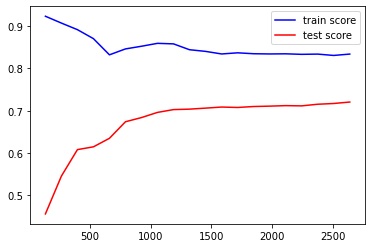

In [201]:
train_scores = lc_svr[1].mean(axis = 1)
test_scores = lc_svr[2].mean(axis = 1)

plt.plot(lc_svr[0], train_scores, color='blue', label="train score")
plt.plot(lc_svr[0], test_scores, color='red', label="test score")
plt.legend()
plt.show()

In [202]:
lc_xgb = learning_curve(rd_xgb, X, y ,train_sizes = np.linspace(0.05, 1, 20))

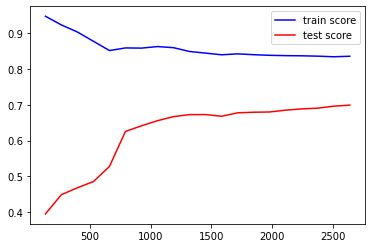

In [203]:
train_scores = lc_xgb[1].mean(axis = 1)
test_scores = lc_xgb[2].mean(axis = 1)

plt.plot(lc_xgb[0], train_scores, color='blue', label="train score")
plt.plot(lc_xgb[0], test_scores, color='red', label="test score")
plt.legend()
plt.show()